In [4]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
%autoreload 2

In [3]:
import sys
sys.version

'3.10.6 (tags/v3.10.6:9c7b4bd, Aug  1 2022, 21:53:49) [MSC v.1932 64 bit (AMD64)]'

In [20]:
from tqdm import tqdm
import time

tqdm()

for i in (pbar:= tqdm(range(10))):
  pbar.set_postfix({'loss': i})
  time.sleep(0.5)

100%|██████████| 10/10 [00:05<00:00,  1.96it/s, loss=9]


In [1]:
from nn.NeuralNet import NN
from layers.FullyConnected import FC
from layers.Flatten import Flatten
from layers.activations.relu import Relu
from layers.Convolution import Conv
from layers.BatchNormalization import BatchNorm
from layers.Pool.MaxPool import MaxPool
from layers.Dropout import Dropout
from loss_functions.softmax_with_cross_entropy import SoftmaxCrossEntropy
from optimizers.adam import Adam
from optimizers.momentum import Momentum

import pickle
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import datasets
%matplotlib inline

In [2]:
def showRandomImage(trainingImages):
    i = np.random.randint(trainingImages.shape[0])
    plt.imshow(trainingImages[i],cmap=plt.get_cmap('gray'))

In [3]:
# Load Mnist dataset
(trainingImages, trainingLabels), (testImages, testLabels) = datasets.mnist.load_data()

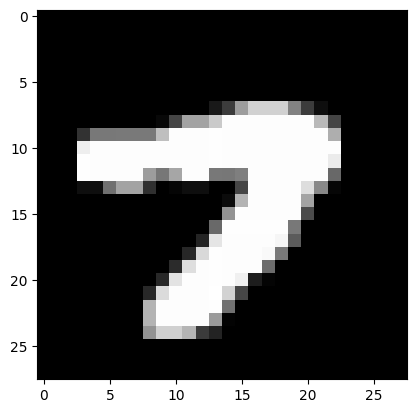

In [4]:
showRandomImage(trainingImages)

In [5]:
# Normalize Image
trainingImages =  trainingImages.astype(np.float32) / 255

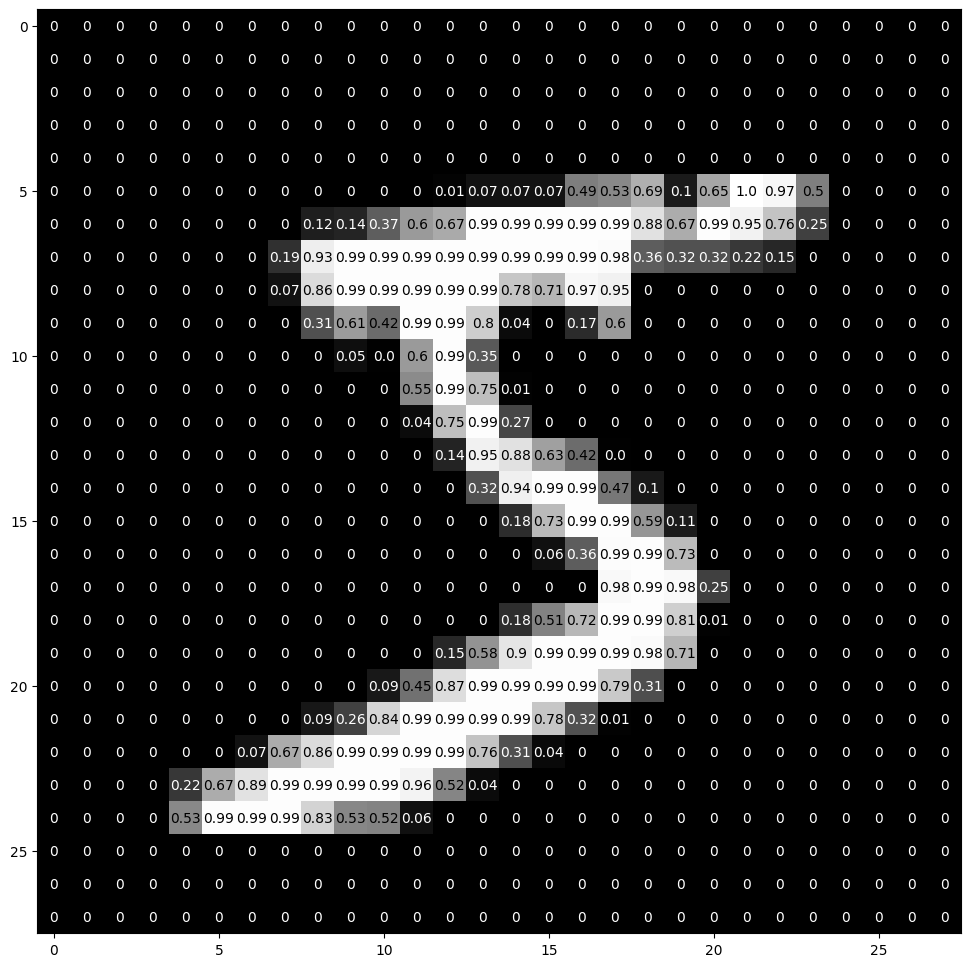

In [6]:
# View an Image in more details
img = np.squeeze(trainingImages[0])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [7]:
#Create model to train network
batch_size = 128
import cupy as cp
trainingImages = cp.array(trainingImages)
trainingLabels = cp.array(trainingLabels)

layers = [
    Flatten(),
    FC(784, 500),
    Relu(),
    Dropout(0.5),
    FC(500, 100),
    Relu(),
    Dropout(0.5),
    FC(100,10)
]

model = NN(layers, SoftmaxCrossEntropy(), Adam())

In [8]:
# Train Model
learning_rate = lambda epoch: 0.0001 if epoch > 10 else 0.001
loss, validation_loss, validation_accuracy = model.train(trainingImages, trainingLabels, 0.2, batch_size, 20, learning_rate, 1)

The validation loss is  0.18684302  Accuracy:  94.46666666666667
The loss after  1  iterations, learning rate is 0.001 iterations is  0.5117465  using  24.12265320000006
The validation loss is  0.14618547  Accuracy:  95.46666666666667
The loss after  2  iterations, learning rate is 0.001 iterations is  0.22303827  using  26.749211499998637
The validation loss is  0.11847822  Accuracy:  96.43333333333334
The loss after  3  iterations, learning rate is 0.001 iterations is  0.16682315  using  29.308365499997308
The validation loss is  0.10735162  Accuracy:  96.775
The loss after  4  iterations, learning rate is 0.001 iterations is  0.14039548  using  31.88672559999759
The validation loss is  0.09801689  Accuracy:  97.10833333333333
The loss after  5  iterations, learning rate is 0.001 iterations is  0.12125016  using  34.32268419999673
The validation loss is  0.08712309  Accuracy:  97.275
The loss after  6  iterations, learning rate is 0.001 iterations is  0.1094188  using  36.65836799999

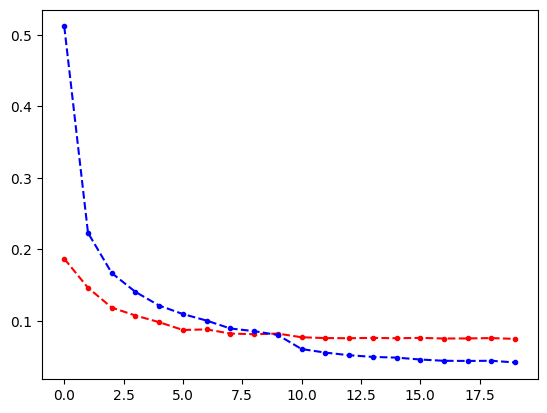

In [9]:
validation_numpy = list(map(lambda loss: cp.asnumpy(loss), validation_loss))
loss_numpy = list(map(lambda l: cp.asnumpy(l),loss))
plt.plot(validation_numpy, 'r', linestyle="--", marker=".")
plt.plot(loss_numpy, 'b', linestyle = "--", marker=".")

plt.show()

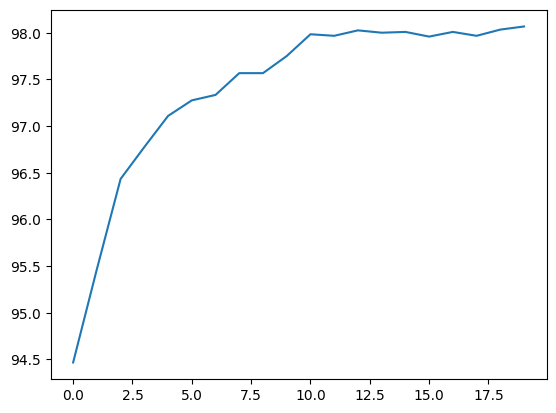

In [10]:
plt.plot(list(map(lambda acc: cp.asnumpy(acc), validation_accuracy)))

#CIFAR-10 

In [5]:
(trainingImages, trainingLabels), (testImages, testLabels) = datasets.cifar10.load_data()
trainingLabels = trainingLabels.reshape(-1)
testLabels = testLabels.reshape(-1)

In [6]:
np.max(trainingImages[1])

254

In [7]:
trainingImages = trainingImages.astype(np.float32) / 255
testImages = testImages.astype(np.float32) / 255

In [8]:
trainingImages[0] = np.flip(trainingImages[0], 0)

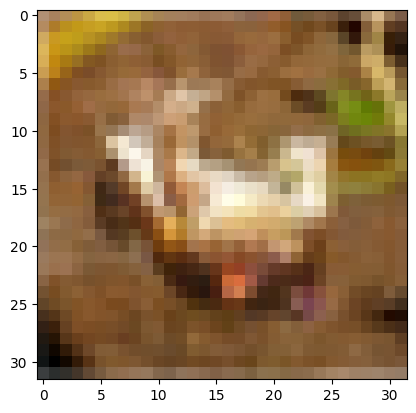

In [9]:
showRandomImage(trainingImages[:1])

In [10]:
trainingImages = (trainingImages - 0.5)/0.5
testImages = (testImages - 0.5)/0.5

In [11]:
import cupy as cp


trainingImages = cp.array(trainingImages)
trainingLabels = cp.array(trainingLabels)
testImages = cp.array(testImages)
testLabels = cp.array(testLabels)

In [12]:
# create the model
batch_size = 128

# layers = [
#     Conv(3,32,(4,4)),
#     BatchNorm(32),
#     Relu(),
#     Conv(32, 32, (3,3), stride=2),
#     BatchNorm(32),
#     Relu(),
#     Conv(32, 64, (3,3)),
#     BatchNorm(64),
#     Relu(),
#     Dropout(0.7),
#     Conv(64, 128, (4,4)),
#     BatchNorm(128),
#     Relu(),
#     Conv(128,256, (3,3), stride=2),
#     BatchNorm(256),
#     Relu(),
#     Flatten(),
#     Dropout(0.5),
#     FC(4096, 500),
#     BatchNorm(500),
#     Relu(),
#     Dropout(0.5),
#     FC(500, 10),
# ]

layers = [
    Conv(3,16,(3,3), padding=1),
    BatchNorm(16),
    Relu(),
    MaxPool(2,2),
    Conv(16, 32, (3,3), padding=1),
    BatchNorm(32),
    Relu(),
    Dropout(0.5),
    Conv(32, 64, (3,3), padding=1),
    BatchNorm(64),
    Relu(),
    MaxPool(2,2),
    Conv(64, 64, (3,3), padding=1),
    BatchNorm(64),
    Relu(),
    Conv(64,128, (3,3), padding=1),
    BatchNorm(128),
    Relu(),
    MaxPool(2,2),
    Flatten(),
    Dropout(0.5),
    FC(128*4*4, 500),
    BatchNorm(500),
    Relu(),
    Dropout(0.5),
    FC(500, 10),
]


model = NN(layers, SoftmaxCrossEntropy(), Adam())

In [13]:
learning_rate = lambda epoch: 0.001 if epoch < 80 else 0.0001
loss, validation_loss, validation_accuracy = model.train(trainingImages[:1000], trainingLabels[:1000], 0.2, batch_size, 3, learning_rate)

Validating: 100%|██████████| 2/2 [00:03<00:00,  1.98s/it, loss=2.3614435, acc=9.0] 


Validating: 100%|██████████| 2/2 [00:00<00:00, 12.56it/s, loss=2.503974, acc=15.5]


Validating: 100%|██████████| 2/2 [00:00<00:00, 12.90it/s, loss=2.497209, acc=10.5]

In [12]:
# Release memory
del trainingImages, trainingLabels
cp._default_memory_pool.free_all_blocks()

In [31]:
validation_loss

[array(3.485873, dtype=float32),
 array(3.6848946, dtype=float32),
 array(3.3811288, dtype=float32),
 array(2.8171248, dtype=float32),
 array(3.0071661, dtype=float32),
 array(2.5321245, dtype=float32),
 array(2.5758808, dtype=float32),
 array(2.5291812, dtype=float32),
 array(2.9496958, dtype=float32),
 array(2.3905306, dtype=float32)]

In [24]:
model.getValidationStats(trainingImages, trainingLabels, 128)

(array(0.205055, dtype=float32), array(94.572))

In [2]:
import torch.nn as nn
import torch
import cupy as cp

In [14]:
inp = np.array([0.1,0.2,0.6,0.7,0.9,0.4, 0.8])
(inp < 0.2) / 0.2

array([5., 0., 0., 0., 0., 0., 0.])

In [13]:
def printThis(x: str):
  print(x)

printThis(34)


34


In [23]:
cp.random.rand(10,) < 0.5

array([False, False,  True, False, False, False,  True,  True, False,
        True])

In [15]:
train.shape

NameError: name 'train' is not defined

In [34]:
np.max(label)

99

In [10]:
a = cp.array([2,3,4])
all = cp.sum(a) / 2
all.astype(cp.float32)

array(4.5, dtype=float32)

In [19]:
pool = nn.MaxPool2d(2, 2)

In [ ]:
before = np.array([[[[2, 0],
   [5, 7],
   [1, 9],
   [1, 6]],

  [[1, 6],
   [8, 1],
   [5, 7],
   [3, 4]],

  [[6, 1],
   [8, 8],
   [7, 7],
   [5, 6]]]])
before.shape

In [ ]:
# x = np.transpose(before, (0,2,3,1))
x = np.random.randint(20, size=(1,2,2,3))
torch_x = torch.Tensor(np.transpose(x, (0,3,1,2)))
torch_x.requires_grad_()
cp_x = cp.array(x)
# print(torch_x)

In [ ]:
m = MaxPool((x.shape[1:]), 2,2)

In [ ]:
torch_ans = pool(torch_x)
torch_ans.retain_grad()
# print(torch_ans.shape)
# print(torch_ans)
print()
# final_ans = np.int32(np.transpose(torch_ans.numpy(), (0,2,3,1)))
# print(final_ans.shape)
# final_ans

In [ ]:
max_torch = m.forward_pass(cp_x).get()
print(max_torch.shape)
# max_torch

In [ ]:
cp_ans = m.backward_pass(cp.ones((1,1,1,3)))

In [ ]:
cp_ans = cp_ans.transpose(0,3,1,2)
print(cp_x.transpose(0,3,1,2))
# print(max_torch.transpose(0,3,1,2))
print(cp_ans)

In [ ]:
summation = torch.sum(torch_ans)

In [ ]:
summation.backward()

In [ ]:
print(torch_x.grad)
print(torch_x)
# torch_ans.shape

In [19]:
x = np.array([[0.003, 3, 8, 14], [0.01, 0.1, 3, 10]])
exp_x = np.exp(x)

print(exp_x)

exp_x/np.sum(exp_x, axis=1, keepdims=True)

[[1.00300450e+00 2.00855369e+01 2.98095799e+03 1.20260428e+06]
 [1.01005017e+00 1.10517092e+00 2.00855369e+01 2.20264658e+04]]


array([[8.31950264e-07, 1.66601124e-05, 2.47257991e-03, 9.97509928e-01],
       [4.58100341e-05, 5.01241613e-05, 9.10963793e-04, 9.98993102e-01]])

In [20]:
p = x - np.max(x, axis=1, keepdims=True)
exp_p = np.exp(p)

print(exp_p)

exp_p/np.sum(exp_p, axis=1, keepdims=True)

[[8.34027051e-07 1.67017008e-05 2.47875218e-03 1.00000000e+00]
 [4.58562066e-05 5.01746821e-05 9.11881966e-04 1.00000000e+00]]


array([[8.31950264e-07, 1.66601124e-05, 2.47257991e-03, 9.97509928e-01],
       [4.58100341e-05, 5.01241613e-05, 9.10963793e-04, 9.98993102e-01]])

In [11]:
a = np.random.randint(1,9, size=(4,3))

In [19]:
b = cp.asarray(a)

'cupy'

In [18]:
a

array([[7, 6, 3],
       [5, 8, 2],
       [5, 6, 2],
       [7, 4, 2]])